In [1]:
!pip install bokeh==2.4.3
!pip install backtesting

In [2]:
import backtesting
backtesting.set_bokeh_output(notebook=True)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy, TrailingStrategy, barssince
import numpy as np
import pandas as pd
#import yfinance package
import yfinance as yf
#import datetime package
import datetime as dt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [3]:
ticker=yf.download('0700.HK', start=dt.datetime(2017,1,1), end=dt.datetime(2022,1,1))
del ticker['Adj Close']
print(ticker)

def BBand(values, nday, nstd):

    BBMID=pd.Series(values).rolling(nday).mean()
    BBSTD=pd.Series(values).rolling(nday).std()
    BBUP=BBMID+BBSTD*nstd
    BBLOW=BBMID-BBSTD*nstd

    return BBUP, BBLOW, BBMID

def SMA(values, nday):

    ma=pd.Series(values).rolling(nday).mean()

    return ma

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close    Volume
Date                                                                
2017-01-03  188.000000  191.100006  188.000000  189.399994   9637272
2017-01-04  190.399994  190.500000  188.100006  189.000000  11411490
2017-01-05  191.000000  194.199997  190.699997  193.300003  20543005
2017-01-06  196.199997  196.800003  194.699997  195.100006  20077760
2017-01-09  196.699997  196.899994  195.199997  195.600006  13605277
...                ...         ...         ...         ...       ...
2021-12-24  460.799988  460.799988  460.799988  460.799988         0
2021-12-28  457.799988  459.200012  445.000000  450.399994  18949609
2021-12-29  443.600006  445.600006  440.399994  444.799988   9589399
2021-12-30  446.399994  450.799988  442.000000  443.399994   7664650
2021-12-31  462.000000  462.000000  455.200012  456.799988   9875225

[1234 rows x 5 columns]


In [4]:
class SmaCross_Basic(Strategy):

    # you can change the parameters here
    nday1=10
    nday2=20

    def init(self):
        Close = self.data.Close
        self.ma1 = self.I(SMA, Close, self.nday1)
        self.ma2 = self.I(SMA, Close, self.nday2)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()

class BBandCross_Basic(Strategy):

    # you can change the parameters here
    nday=50
    nstd=2

    def init(self):
        self.BBUP, self.BBLOW, self.BBMID = self.I(BBand, self.data.Close, self.nday, self.nstd)

    def next(self):
        # If Close crosses above BBandUP, buy the asset
        if crossover(self.BBUP,self.data.Close):
            self.buy()

        # Else, if Close crosses below BBandLow, sell it
        elif crossover(self.data.Close,self.BBLOW):
            self.sell()

In [5]:
class SmaCross_Refine(Strategy):

    # you can change the parameters here
    nday1=10
    nday2=20

    def init(self):
        Close = self.data.Close
        self.ma1 = self.I(SMA, Close, self.nday1)
        self.ma2 = self.I(SMA, Close, self.nday2)

    def next(self):
        if crossover(self.ma1, self.ma2):
          self.buy()
          if crossover(self.ma1, self.data.Close):
            self.sell()

        elif crossover(self.ma2, self.ma1):
          self.sell()
          if crossover(self.data.Close, self.ma2):
            self.buy()

        elif crossover(self.data.Close, self.ma1):
          self.buy()
          if crossover(self.ma1, self.data.Close):
            self.sell()

        elif crossover(self.data.Close, self.ma2):
          self.buy()
          if crossover(self.ma2, self.data.Close):
            self.sell()

class BBandCross_Refine(Strategy):

    # you can change the parameters here
    nday=50
    nstd=2

    def init(self):
        self.BBUP, self.BBLOW, self.BBMID = self.I(BBand, self.data.Close, self.nday, self.nstd)

    def next(self):
        # If Close crosses above BBandUP, buy the asset
        if crossover(self.BBUP,self.data.Close):
          self.buy()
          if crossover(self.data.Close, self.BBUP):
            self.sell()

        if crossover(self.BBLOW,self.data.Close):
          self.buy()
          if crossover(self.data.Close,self.BBLOW):
            self.sell()

        # Else, if Close crosses below BBandLow, sell it
        if crossover(self.data.Close,self.BBLOW):
          self.sell()
          if crossover(self.BBLOW,self.data.Close):
            self.buy()


        # Else, if Close crosses below BBandLow, sell it
        elif crossover(self.data.Close,self.BBLOW):
          self.sell()
          if crossover(self.BBLOW,self.data.Close):
            self.buy()

In [6]:
bt_sma_basic = Backtest(ticker, SmaCross_Basic, commission=.001, exclusive_orders=True, trade_on_close=True)
result_sma_basic=bt_sma_basic.run()
bt_sma_basic.plot(show_legend=True)

Row(id='1449', ...)

In [7]:
print(result_sma_basic)

Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   96.272285
Equity Final [$]                 10669.340676
Equity Peak [$]                  15806.384062
Return [%]                           6.693407
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                    1.331877
Volatility (Ann.) [%]               32.798264
Sharpe Ratio                         0.040608
Sortino Ratio                         0.05966
Calmar Ratio                         0.035937
Max. Drawdown [%]                  -37.060964
Avg. Drawdown [%]                   -6.532341
Max. Drawdown Duration      757 days 00:00:00
Avg. Drawdown Duration       79 days 00:00:00
# Trades                                   63
Win Rate [%]                        41.269841
Best Trade [%]                      22.884363
Worst Trade [%]                    -10.297966
Avg. Trade [%]                    

In [8]:
bt_sma_refine = Backtest(ticker, SmaCross_Refine, commission=.001, exclusive_orders=True, trade_on_close=True)
result_sma_refine=bt_sma_refine.run()
bt_sma_refine.plot(show_legend=True)

Row(id='2181', ...)

In [9]:
print(result_sma_refine)

Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   97.568882
Equity Final [$]                  6427.330073
Equity Peak [$]                  15331.893001
Return [%]                         -35.726699
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                   -8.631357
Volatility (Ann.) [%]               30.857289
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -60.443221
Avg. Drawdown [%]                   -5.645991
Max. Drawdown Duration     1501 days 00:00:00
Avg. Drawdown Duration       98 days 00:00:00
# Trades                                  198
Win Rate [%]                        45.454545
Best Trade [%]                       20.86844
Worst Trade [%]                    -17.135873
Avg. Trade [%]                    

In [10]:
bt_bband_basic = Backtest(ticker, BBandCross_Basic, commission=.001, exclusive_orders=True, trade_on_close=True)
result_bband_basic=bt_bband_basic.run()
bt_bband_basic.plot(show_legend=True)

Row(id='2932', ...)

In [11]:
print(result_bband_basic)

Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   95.461912
Equity Final [$]                  8940.284897
Equity Peak [$]                   23006.60227
Return [%]                         -10.597151
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                    -2.26159
Volatility (Ann.) [%]               35.928535
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -71.378839
Avg. Drawdown [%]                   -5.283481
Max. Drawdown Duration     1158 days 00:00:00
Avg. Drawdown Duration       55 days 00:00:00
# Trades                                   47
Win Rate [%]                        70.212766
Best Trade [%]                      21.688057
Worst Trade [%]                    -36.091147
Avg. Trade [%]                    

In [12]:
bt_bband_refine = Backtest(ticker, BBandCross_Refine, commission=.001, exclusive_orders=True, trade_on_close=True)
result_bband_refine=bt_bband_refine.run()
bt_bband_refine.plot(show_legend=True)

Row(id='3683', ...)

In [13]:
print(result_bband_refine)

Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   95.461912
Equity Final [$]                  9622.723943
Equity Peak [$]                  23132.888376
Return [%]                          -3.772761
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                   -0.782284
Volatility (Ann.) [%]               36.940933
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -66.664179
Avg. Drawdown [%]                   -4.927287
Max. Drawdown Duration     1157 days 00:00:00
Avg. Drawdown Duration       55 days 00:00:00
# Trades                                   65
Win Rate [%]                        70.769231
Best Trade [%]                      21.688057
Worst Trade [%]                    -36.091147
Avg. Trade [%]                    

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1444 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/backtesting/_stats.py:114: RuntimeWarning: overflow encountered in double_scalars
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gmean_day_return)**2)**annual_trading_days - (1 + gmean_day_return)**(2*annual_trading_days)) * 100  # noqa: E501
/usr/local/lib/python3.10/dist-packages/backtesting/_stats.py:114: RuntimeWarning: overflow encountered in double_scalars
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gmean_day_return)**2)**annual_trading_days - (1 + gmean_day_return)**(2*annual_trading_days)) * 100  # noqa: E501


Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   71.636953
Equity Final [$]                 24661.016222
Equity Peak [$]                  25349.215654
Return [%]                         146.610162
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                   20.241422
Volatility (Ann.) [%]               31.830421
Sharpe Ratio                         0.635914
Sortino Ratio                        1.165297
Calmar Ratio                         0.735755
Max. Drawdown [%]                  -27.511109
Avg. Drawdown [%]                   -5.867024
Max. Drawdown Duration      289 days 00:00:00
Avg. Drawdown Duration       39 days 00:00:00
# Trades                                    5
Win Rate [%]                             80.0
Best Trade [%]                      60.109597
Worst Trade [%]                     -4.830521
Avg. Trade [%]                    

<Axes: xlabel='nday2', ylabel='nday1'>

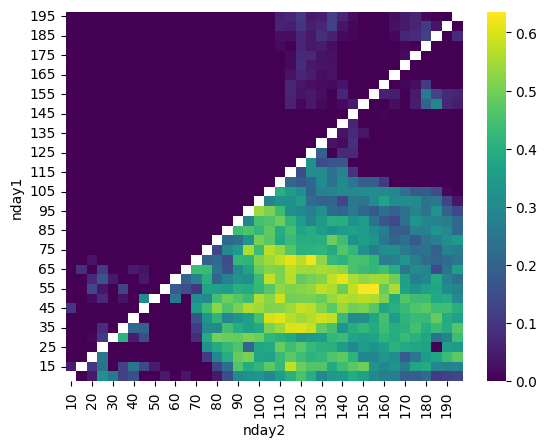

In [14]:
#For SMACross Strategy:
#Python will try all sets of parameters:
#nday1 from 10 to 200 by 5
#nday2 from 10 to 200 by 5
stats, heatmap = bt_sma_basic.optimize(

                    nday1=range(10,200,5),
                    nday2=range(10,200,5),

                    maximize='Sharpe Ratio',

                    return_heatmap=True)
print(stats)

#Yellow areas refer to high Sharpe parameter sets
hm = heatmap.groupby(['nday1', 'nday2']).mean().unstack()

sns.heatmap(hm[::-1], cmap='viridis')

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1444 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/5 [00:00<?, ?it/s]

Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   81.118314
Equity Final [$]                   27984.1853
Equity Peak [$]                  36798.617047
Return [%]                         179.841853
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                   23.385975
Volatility (Ann.) [%]                36.55922
Sharpe Ratio                         0.639674
Sortino Ratio                        1.185278
Calmar Ratio                         0.890987
Max. Drawdown [%]                  -26.247267
Avg. Drawdown [%]                   -5.612006
Max. Drawdown Duration      390 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                   45
Win Rate [%]                        62.222222
Best Trade [%]                      35.148451
Worst Trade [%]                     -9.275148
Avg. Trade [%]                    

<Axes: xlabel='nday2', ylabel='nday1'>

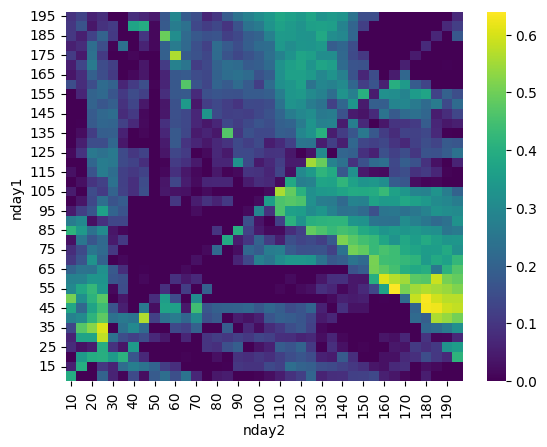

In [15]:
#For SMACross Strategy:
#Python will try all sets of parameters:
#nday1 from 10 to 200 by 5
#nday2 from 10 to 200 by 5
stats, heatmap = bt_sma_refine.optimize(

                    nday1=range(10,200,5),
                    nday2=range(10,200,5),

                    maximize='Sharpe Ratio',

                    return_heatmap=True)
print(stats)

#Yellow areas refer to high Sharpe parameter sets
hm = heatmap.groupby(['nday1', 'nday2']).mean().unstack()

sns.heatmap(hm[::-1], cmap='viridis')

In [16]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   81.199352
Equity Final [$]                 32237.058376
Equity Peak [$]                  34571.909406
Return [%]                         222.370584
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                   27.002789
Volatility (Ann.) [%]               38.800988
Sharpe Ratio                          0.69593
Sortino Ratio                        1.376044
Calmar Ratio                         1.091473
Max. Drawdown [%]                  -24.739774
Avg. Drawdown [%]                   -5.747019
Max. Drawdown Duration      245 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                   54
Win Rate [%]                        55.555556
Best Trade [%]                      25.430481
Worst Trade [%]                     -7.133882
Avg. Trade [%]                    

<Axes: xlabel='nstd', ylabel='nday'>

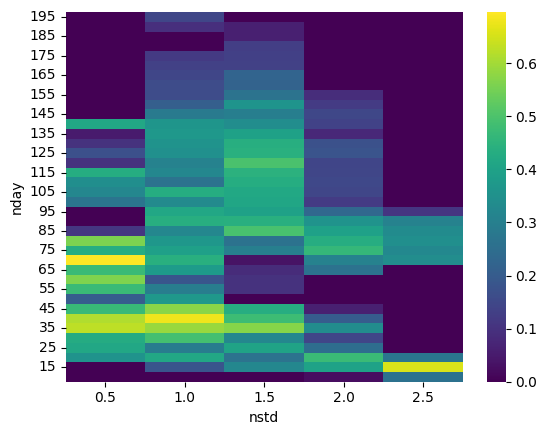

In [17]:
#For BBandCross Strategy:
#Python will try all sets of parameters:
#nday from 10 to 200 by 5
#nstd from 0.5 to 3 by 0.5
stats, heatmap = bt_bband_basic.optimize(

                    nday=range(10,200,5),
                    nstd=list(frange(0.5,3,0.5)),

                    maximize='Sharpe Ratio',

                    return_heatmap=True)
print(stats)

#Yellow areas refer to high Sharpe parameter sets
hm = heatmap.groupby(['nday', 'nstd']).mean().unstack()

sns.heatmap(hm[::-1], cmap='viridis')

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Start                     2017-01-03 00:00:00
End                       2021-12-31 00:00:00
Duration                   1823 days 00:00:00
Exposure Time [%]                   96.677472
Equity Final [$]                 34732.677012
Equity Peak [$]                  40176.481517
Return [%]                          247.32677
Buy & Hold Return [%]              141.182683
Return (Ann.) [%]                   28.951468
Volatility (Ann.) [%]               45.825588
Sharpe Ratio                         0.631775
Sortino Ratio                        1.280803
Calmar Ratio                         1.021877
Max. Drawdown [%]                  -28.331656
Avg. Drawdown [%]                   -5.396221
Max. Drawdown Duration      238 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                  138
Win Rate [%]                         68.84058
Best Trade [%]                       30.29607
Worst Trade [%]                    -19.707726
Avg. Trade [%]                    

<Axes: xlabel='nstd', ylabel='nday'>

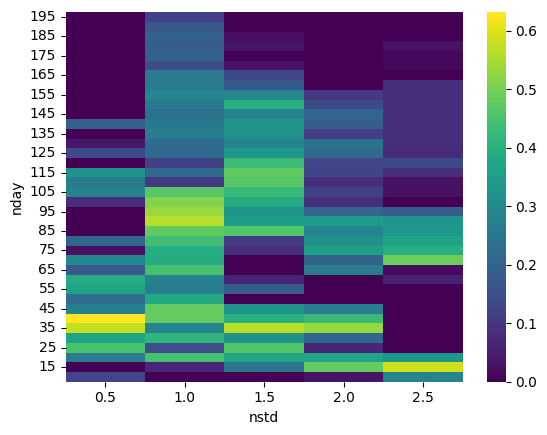

In [18]:
#For BBandCross Strategy:
#Python will try all sets of parameters:
#nday from 10 to 200 by 5
#nstd from 0.5 to 3 by 0.5
stats, heatmap = bt_bband_refine.optimize(

                    nday=range(10,200,5),
                    nstd=list(frange(0.5,3,0.5)),

                    maximize='Sharpe Ratio',

                    return_heatmap=True)
print(stats)

#Yellow areas refer to high Sharpe parameter sets
hm = heatmap.groupby(['nday', 'nstd']).mean().unstack()

sns.heatmap(hm[::-1], cmap='viridis')